# Get Protein Structure and Ligands from PDB
This is taken from the [tutorial](https://projects.volkamerlab.org/teachopencadd/talktorials/T008_query_pdb.html) provided by TeachOpenCADD.

The goal for this notebook is to be able to bring the structures into PyMol and then look at the binding pocket.

In [2]:
# Imports
import collections
import logging
import pathlib
import time
import warnings
import datetime

import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
from tqdm.auto import tqdm
import redo
import requests_cache
import nglview
import pypdb
import biotite.database.rcsb as rcsb
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools

# Disable some unneeded warnings
logger = logging.getLogger("opencadd")
logger.setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

# Cache requests -- this will speed up repeated queries to PDB
requests_cache.install_cache("rcsb_pdb", backend="memory")

In [3]:
# Define paths
HERE = pathlib.Path(_dh[-1])
DATA = HERE / "data"

In [5]:
uniprot_id = "P00734"
experimental_method = "X-RAY DIFFRACTION"
max_resolution = 2.0
min_ligand_molecular_weight = 100.0

### Get the Number of PDB entries for the query protein

In [6]:
query_by_uniprot_id = rcsb.FieldQuery(
    "rcsb_polymer_entity_container_identifiers.reference_sequence_identifiers.database_accession",
    exact_match=uniprot_id,
)
today = datetime.datetime.now()
print(
    f"Number of structures on {today.year}-{today.month}-{today.day}: {rcsb.count(query_by_uniprot_id)}"
)

Number of structures on 2025-1-20: 469


### Select a PDB structure with the Highest Resolution

In [7]:
@redo.retriable(attempts=10, sleeptime=2)
def describe_one_pdb_id(pdb_id):
    """Fetch meta information from PDB."""
    described = pypdb.describe_pdb(pdb_id)
    if described is None:
        print(f"! Error while fetching {pdb_id}, retrying ...")
        raise ValueError(f"Could not fetch PDB id {pdb_id}")
    return described

In [8]:
query_by_uniprot_id = rcsb.FieldQuery(
    "rcsb_polymer_entity_container_identifiers.reference_sequence_identifiers.database_accession",
    exact_match=uniprot_id,
)
query_by_experimental_method = rcsb.FieldQuery("exptl.method", exact_match=experimental_method)
query_by_resolution = rcsb.FieldQuery(
    "rcsb_entry_info.resolution_combined", less_or_equal=max_resolution
)
query_by_ligand_mw = rcsb.FieldQuery(
    "chem_comp.formula_weight", molecular_definition=True, greater=min_ligand_molecular_weight
)
query = rcsb.CompositeQuery(
    [
        query_by_uniprot_id,
        query_by_experimental_method,
        query_by_ligand_mw
    ],
    "and",
)
pdb_ids = rcsb.search(query)
print(f"Number of matches: {len(pdb_ids)}")
print("Selected PDB IDs:")
print(*pdb_ids)

Number of matches: 460
Selected PDB IDs:
1A2C 1A3B 1A3E 1A46 1A4W 1A5G 1A61 1ABI 1ABJ 1AD8 1AE8 1AFE 1AHT 1AI8 1AIX 1AWF 1AWH 1AY6 1B5G 1B7X 1BA8 1BB0 1BCU 1BHX 1BMM 1BMN 1BTH 1C1U 1C1V 1C1W 1C4U 1C4V 1C4Y 1C5L 1C5N 1C5O 1CA8 1D3D 1D3P 1D3Q 1D3T 1D4P 1D6W 1D9I 1DE7 1DIT 1DM4 1DOJ 1DWB 1DWC 1DWD 1DWE 1DX5 1E0F 1EB1 1EOJ 1EOL 1FPC 1FPH 1G30 1G32 1G37 1GHV 1GHW 1GHX 1GHY 1GJ4 1GJ5 1H8D 1H8I 1HAG 1HAH 1HAI 1HAO 1HAP 1HBT 1HDT 1HGT 1HLT 1HUT 1HXE 1HXF 1IHS 1IHT 1JMO 1JOU 1JWT 1K21 1K22 1KTS 1KTT 1LHC 1LHD 1LHE 1LHF 1LHG 1MH0 1MU6 1MU8 1MUE 1NM6 1NO9 1NRN 1NRO 1NRP 1NRQ 1NRR 1NRS 1NT1 1NU7 1NU9 1NY2 1NZQ 1O0D 1O2G 1O5G 1OOK 1OYT 1P8V 1PPB 1QBV 1QHR 1QJ1 1QJ6 1QJ7 1QUR 1RD3 1RIW 1SB1 1SFQ 1SG8 1SGI 1SHH 1SL3 1SR5 1T4U 1T4V 1TA2 1TA6 1TB6 1TBZ 1THP 1THR 1THS 1TMB 1TMT 1TMU 1TOM 1TQ0 1TQ7 1TWX 1UMA 1UVS 1VR1 1VZQ 1W7G 1WAY 1WBG 1XM1 1XMN 1YPE 1YPG 1YPJ 1YPK 1YPL 1YPM 1Z71 1Z8I 1Z8J 1ZGI 1ZGV 1ZRB 2A0Q 2A2X 2A45 2AFQ 2ANK 2ANM 2B5T 2BDY 2BVR 2BVS 2BVX 2BXT 2BXU 2C8W 2C8X 2C8Y 2C8Z 2C90 2C93 2CF8

In [9]:
pdbs_data = [describe_one_pdb_id(pdb_id) for pdb_id in tqdm(pdb_ids)]

  0%|          | 0/460 [00:00<?, ?it/s]

In [10]:
# Get the resolution of each structure
resolution = pd.DataFrame(
    [
        [pdb_data["entry"]["id"], pdb_data["rcsb_entry_info"]["resolution_combined"][0]]
        for pdb_data in pdbs_data
    ],
    columns=["pdb_id", "resolution"],
).sort_values(by="resolution", ignore_index=True)
resolution

,pdb_id,resolution
0,5AFY,1.120
1,4UD9,1.124
2,4UE7,1.129
3,4UDW,1.160
4,4UEH,1.160
...,...,...
455,1NRQ,3.500
456,5EW2,3.590
457,2A45,3.650
458,6C2W,4.120


In [11]:
# Filter the structures based on the resolution manually using the dataframe
resolutions_filtered = resolution[resolution["resolution"] <= max_resolution]
resolutions_filtered.head()

,pdb_id,resolution
0,5AFY,1.120
1,4UD9,1.124
2,4UE7,1.129
3,4UDW,1.160
4,4UEH,1.160


In [15]:
# Select the top 10 structures for ligand search
top_num = 20
selected_pdb_ids = resolutions_filtered[:top_num]["pdb_id"].to_list()
print(f"Selected PDB IDs: {selected_pdb_ids}")

Selected PDB IDs: ['5AFY', '4UD9', '4UE7', '4UDW', '4UEH', '5AF9', '3RM2', '5AHG', '3VXE', '2BVR', '2UUF', '5JZY', '6FJT', '3SI4', '3U8O', '5MM6', '3SV2', '2CF8', '2CN0', '6TKL']


### Get the ligand structures 
In this section I am getting the ligand structures from the PDB data provided.

In [16]:
def get_ligands(pdb_id):
    """
    RCSB has not provided a new endpoint for ligand information yet. As a
    workaround we are obtaining extra information from ligand-expo.rcsb.org,
    using HTML parsing. Check Talktorial T011 for more info on this technique!
    """
    pdb_info = _fetch_pdb_nonpolymer_info(pdb_id)
    ligand_expo_ids = [
        nonpolymer_entities["pdbx_entity_nonpoly"]["comp_id"]
        for nonpolymer_entities in pdb_info["data"]["entry"]["nonpolymer_entities"]
    ]

    ligands = {}
    for ligand_expo_id in ligand_expo_ids:
        ligand_expo_info = _fetch_ligand_expo_info(ligand_expo_id)
        ligands[ligand_expo_id] = ligand_expo_info

    return ligands


def _fetch_pdb_nonpolymer_info(pdb_id):
    """
    Fetch nonpolymer data from rcsb.org.
    Thanks @BJWiley233 and Rachel Green for this GraphQL solution.
    """
    query = (
        """{
          entry(entry_id: "%s") {
            nonpolymer_entities {
              pdbx_entity_nonpoly {
                comp_id
                name
                rcsb_prd_id
              }
            }
          }
        }"""
        % pdb_id
    )

    query_url = f"https://data.rcsb.org/graphql?query={query}"
    response = requests.get(query_url)
    response.raise_for_status()
    info = response.json()
    return info


def _fetch_ligand_expo_info(ligand_expo_id):
    """
    Fetch ligand data from ligand-expo.rcsb.org.
    """
    r = requests.get(f"http://ligand-expo.rcsb.org/reports/{ligand_expo_id[0]}/{ligand_expo_id}/")
    r.raise_for_status()
    html = BeautifulSoup(r.text)
    info = {}
    for table in html.find_all("table"):
        for row in table.find_all("tr"):
            cells = row.find_all("td")
            if len(cells) != 2:
                continue
            key, value = cells
            if key.string and key.string.strip():
                info[key.string.strip()] = "".join(value.find_all(string=True))

    # Postprocess some known values
    info["Molecular weight"] = float(info["Molecular weight"].split()[0])
    info["Formal charge"] = int(info["Formal charge"])
    info["Atom count"] = int(info["Atom count"])
    info["Chiral atom count"] = int(info["Chiral atom count"])
    info["Bond count"] = int(info["Bond count"])
    info["Aromatic bond count"] = int(info["Aromatic bond count"])
    return info

In [17]:
columns = [
    "@structureId",
    "@chemicalID",
    "@type",
    "@molecularWeight",
    "chemicalName",
    "formula",
    "InChI",
    "InChIKey",
    "smiles",
]
rows = []
for pdb_id in selected_pdb_ids:
    ligands = get_ligands(pdb_id)
    # If several ligands contained, take largest (first in results)
    ligand_id, properties = max(ligands.items(), key=lambda kv: kv[1]["Molecular weight"])
    rows.append(
        [
            pdb_id,
            ligand_id,
            properties["Component type"],
            properties["Molecular weight"],
            properties["Name"],
            properties["Formula"],
            properties["InChI descriptor"],
            properties["InChIKey descriptor"],
            properties["Stereo SMILES (OpenEye)"],
        ]
    )

In [18]:
# NBVAL_CHECK_OUTPUT
# Change the format to DataFrame
ligands = pd.DataFrame(rows, columns=columns)
ligands

,@structureId,@chemicalID,@type,@molecularWeight,chemicalName,formula,InChI,InChIKey,smiles
0,5AFY,NAG,"D-saccharide, beta linking",221.208,2-acetamido-2-deoxy-beta-D-glucopyranose,C8 H15 N O6,InChI=1S/C8H15NO6/c1-3(11)9-5-7(13)6(12)4(2-10...,OVRNDRQMDRJTHS-FMDGEEDCSA-N,CC(=O)N[C@@H]1[C@H]([C@@H]([C@H](O[C@H]1O)CO)O)O
1,4UD9,NAG,"D-saccharide, beta linking",221.208,2-acetamido-2-deoxy-beta-D-glucopyranose,C8 H15 N O6,InChI=1S/C8H15NO6/c1-3(11)9-5-7(13)6(12)4(2-10...,OVRNDRQMDRJTHS-FMDGEEDCSA-N,CC(=O)N[C@@H]1[C@H]([C@@H]([C@H](O[C@H]1O)CO)O)O
2,4UE7,NAG,"D-saccharide, beta linking",221.208,2-acetamido-2-deoxy-beta-D-glucopyranose,C8 H15 N O6,InChI=1S/C8H15NO6/c1-3(11)9-5-7(13)6(12)4(2-10...,OVRNDRQMDRJTHS-FMDGEEDCSA-N,CC(=O)N[C@@H]1[C@H]([C@@H]([C@H](O[C@H]1O)CO)O)O
3,4UDW,N6L,NON-POLYMER,420.332,"D-phenylalanyl-N-(2,5-dichlorobenzyl)-L-prolin...",C21 H23 Cl2 N3 O2,InChI=1S/C21H23Cl2N3O2/c22-16-8-9-17(23)15(12-...,XSOBNETYEYXSCD-MOPGFXCFSA-N,c1ccc(cc1)C[C@H](C(=O)N2CCC[C@H]2C(=O)NCc3cc(c...
4,4UEH,NAG,"D-saccharide, beta linking",221.208,2-acetamido-2-deoxy-beta-D-glucopyranose,C8 H15 N O6,InChI=1S/C8H15NO6/c1-3(11)9-5-7(13)6(12)4(2-10...,OVRNDRQMDRJTHS-FMDGEEDCSA-N,CC(=O)N[C@@H]1[C@H]([C@@H]([C@H](O[C@H]1O)CO)O)O
5,5AF9,SJR,NON-POLYMER,228.247,4-methoxy-N-(pyridin-2-yl)benzamide,C13 H12 N2 O2,InChI=1S/C13H12N2O2/c1-17-11-7-5-10(6-8-11)13(...,YFXWAMDABVLKSA-UHFFFAOYSA-N,COc1ccc(cc1)C(=O)Nc2ccccn2
6,3RM2,S00,peptide-like,553.716,N-(benzylsulfonyl)-3-cyclohexyl-D-alanyl-N-(4-...,C29 H39 N5 O4 S,InChI=1S/C29H39N5O4S/c30-27(31)24-15-13-22(14-...,DJNNZKJZFCRFRX-FTJBHMTQSA-N,[H]/N=C(/c1ccc(cc1)CNC(=O)[C@@H]2CCCN2C(=O)[C@...
7,5AHG,Y4L,non-polymer,234.703,((4-Chlorophenyl)sulfamoyl))dimethylamine,C8 H11 Cl N2 O2 S,"InChI=1S/C8H11ClN2O2S/c1-11(2)14(12,13)10-8-5-...",KDRCAWRLJXSNGE-UHFFFAOYSA-N,CN(C)S(=O)(=O)Nc1ccc(cc1)Cl
8,3VXE,NAG,"D-saccharide, beta linking",221.208,2-acetamido-2-deoxy-beta-D-glucopyranose,C8 H15 N O6,InChI=1S/C8H15NO6/c1-3(11)9-5-7(13)6(12)4(2-10...,OVRNDRQMDRJTHS-FMDGEEDCSA-N,CC(=O)N[C@@H]1[C@H]([C@@H]([C@H](O[C@H]1O)CO)O)O
9,2BVR,4CP,NON-POLYMER,405.902,2-[2-(4-CHLORO-PHENYLSULFANYL)-ACETYLAMINO]-3-...,C18 H20 Cl N5 O2 S,InChI=1S/C18H20ClN5O2S/c19-12-3-7-14(8-4-12)27...,IEEYGOJDTRVYGR-HNNXBMFYSA-N,[H]/N=C(\N)/Nc1ccc(cc1)C[C@@H](C(=O)N)NC(=O)CS...


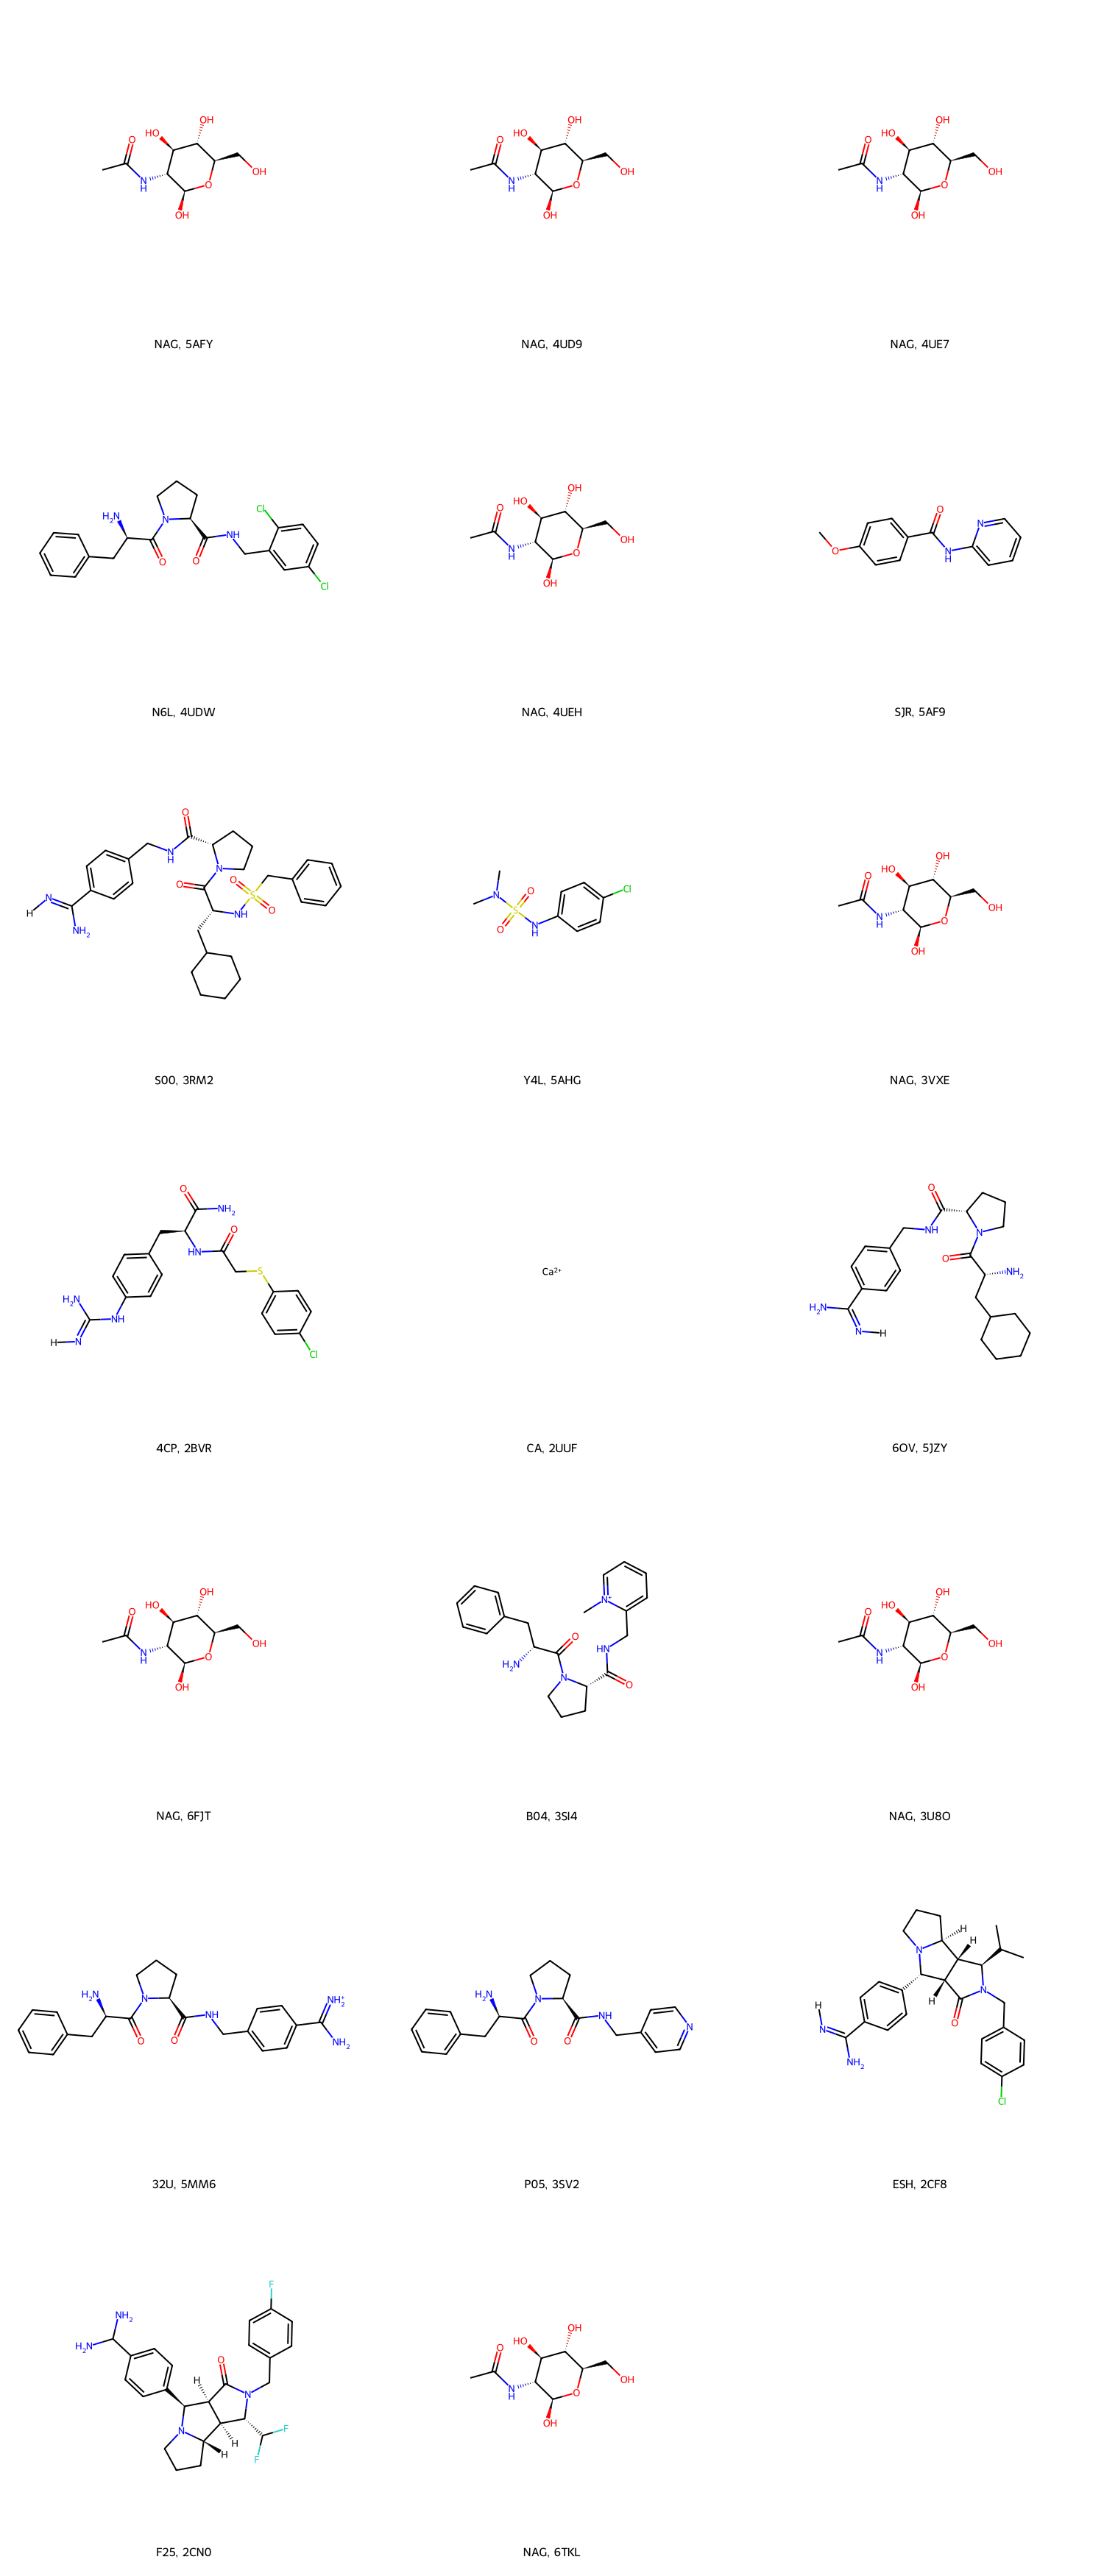

In [26]:
# Draw Ligand Molecules
PandasTools.AddMoleculeColumnToFrame(ligands, "smiles")
Draw.MolsToGridImage(
    mols=list(ligands.ROMol),
    legends=list(ligands["@chemicalID"] + ", " + ligands["@structureId"]),
    molsPerRow=3,
      subImgSize=(500, 500)
)

In [32]:
output = ' '.join(map(str, ligands['@structureId'].values))
print(output)

5AFY 4UD9 4UE7 4UDW 4UEH 5AF9 3RM2 5AHG 3VXE 2BVR 2UUF 5JZY 6FJT 3SI4 3U8O 5MM6 3SV2 2CF8 2CN0 6TKL


In [33]:
ligands['@structureId'].values

array(['5AFY', '4UD9', '4UE7', '4UDW', '4UEH', '5AF9', '3RM2', '5AHG',
       '3VXE', '2BVR', '2UUF', '5JZY', '6FJT', '3SI4', '3U8O', '5MM6',
       '3SV2', '2CF8', '2CN0', '6TKL'], dtype=object)